In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math, scipy, skimage, os
import matplotlib as mpl
import seaborn as sns
from datetime import datetime

mpl.rcParams['font.family'] = 'Calibri'
mpl.rcParams['font.size'] = 12
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
def closest(lst, K):
    lst = np.asarray(lst)
    idx = (np.abs(lst - K)).argmin()
    return [int(idx), lst[idx]]


def find_lin_zone(array, lin_detect_start=5, lin_detect_end=5+10):
    xs = len(array)
    rvalues = []
    for i in range(lin_detect_start, xs):
        array_to_check = array[:i]
        res = scipy.stats.linregress(np.arange(i), array_to_check)
        # fig,ax=plt.subplots()
        # ax.plot(np.arange(i), array_to_check)
        # plt.show()
        rvalues.append(abs(res.rvalue))
        # print('frame', i, ':', abs(res.rvalue))
    lin_end = np.argmax(rvalues) + lin_detect_start
    # print('R_square value max: frame', lin_end)

    if lin_end > lin_detect_end:
        # print('It exceeds the lin_detect_end')
        lin_end = lin_detect_end
    # print('Final linear range: frame 1 -', lin_end)
    return lin_end


def init_vel(recoil_boundaries, pixel_size, time_interval, axs, lin_detect_start = 5, lin_detect_end = 15, start=0):
    boundaries_width = np.abs(recoil_boundaries[:, 1] - recoil_boundaries[:, 0])
    boundaries_width -= boundaries_width[0]
    fs = len(boundaries_width)
    lin_end = find_lin_zone(boundaries_width, lin_detect_start=lin_detect_start, lin_detect_end=lin_detect_end)

    res = scipy.stats.linregress(np.arange(lin_end), boundaries_width[:lin_end])
    vel = res.slope * pixel_size / time_interval

    if axs !=0:
        for ax in axs:
            ax.plot(range(start, start+fs), boundaries_width)
            # ax.axvline(x=lin_end-1, ls='--', color='gray')
            ax.plot(range(start, start+lin_end), boundaries_width[:lin_end], lw=3, color='tab:orange')
            ax.set_xlabel('Frames post cut')
            ax.set_ylabel('Normalized cut size (pixel)')

    return [boundaries_width, lin_end, vel]


def index_to_half_total(arr):
    """
    Returns the index at which the cumulative sum of the array reaches
    or exceeds half of the total sum.

    Parameters:
        arr (array-like): A list or NumPy array of numbers.

    Returns:
        int: Index at which cumulative sum >= 0.5 * total sum.
    """
    arr = np.asarray(arr)
    total = np.sum(arr)
    half = 0.5 * total
    cum_sum = np.cumsum(arr)

    for i, val in enumerate(cum_sum):
        if val >= half:
            return i

    return len(arr) - 1  # in case it never reaches half (e.g., empty or all zeros)

In [3]:
folder = "H:\\Xin home drive\\data_meroblastic\\Laser_cutter\\laser_cutter_ii\\"
wt_perp = ['xin250328_lcii_wt', 'xin250401_lcii_wt', 'xin250402_lcii_wt']

In [4]:
data_collection = pd.read_excel('B:\\home\\Xin home drive\\data_meroblastic\\majority_data_info.xlsx', sheet_name = 'lcii',
                                converters={'rep':int, 'cut_no':int, 'pre_cut_frame_num':int, 'post_cut_frame':int, 'rv_analysis_unit':str, 'rv_analysis_method':str, 'rv_analysis_date':str})
data_collection = data_collection.loc[data_collection['processed']=='processed']
data_collection

rep         experiment cut_type  batch  cut_no   where orientation  \
62      62  xin250328_lcii_wt       wt    2.0       1  middle        perp   
63      63  xin250328_lcii_wt       wt    2.0       2    edge        perp   
64      64  xin250328_lcii_wt       wt    2.0       3  middle        perp   
65      65  xin250328_lcii_wt       wt    2.0       4  middle        perp   
66      66  xin250328_lcii_wt       wt    2.0       5    edge        perp   
...    ...                ...      ...    ...     ...     ...         ...   
1013  1013  xin250710_lcii_wt       wt    2.0      59      ac        perp   
1014  1014  xin250710_lcii_wt       wt    2.0      60      ac        para   
1015  1015  xin250710_lcii_wt       wt    2.0      61      ac        perp   
1016  1016  xin250710_lcii_wt       wt    2.0      62     NaN         NaN   
1017  1017  xin250710_lcii_wt       wt    3.0      63     NaN         NaN   

                                      note  processed  pixel_size  ...  \
62                                     NaN  processed     0.16157  ...   
63                                     NaN  processed     0.16157  ...   
64                                     NaN  processed     0.16157  ...   
65                                     NaN  processed     0.16157  ...   
66                                  phase2  processed     0.16157  ...   
...                                    ...        ...         ...  ...   
1013                                   NaN  processed     0.16157  ...   
1014                                   NaN  processed     0.16157  ...   
1015                                   NaN  processed     0.16157  ...   
1016  cut the septum with little recoiling  processed     0.16157  ...   
1017                                   NaN  processed     0.16157  ...   

      rv_analysis_method  rv_analysis_date  rv_manual  rv_manual_angle1  \
62             automatic       250723_1351        NaN               NaN   
63             automatic       250723_1351        NaN               NaN   
64             automatic       250723_1351        NaN               NaN   
65             automatic       250723_1351        NaN               NaN   
66             automatic       250723_1351        NaN               NaN   
...                  ...               ...        ...               ...   
1013                 NaN               NaN        NaN               NaN   
1014                 NaN               NaN        NaN               NaN   
1015                 NaN               NaN        NaN               NaN   
1016                 NaN               NaN        NaN               NaN   
1017                 NaN               NaN        NaN               NaN   

      rv_manual_angle2  Unnamed: 31 recoiling_analysis1 recoiling_analysis2  \
62                 NaN          NaN                 8.0               4.255   
63                 NaN          NaN                 8.0               2.908   
64                 NaN          NaN                 9.0               4.686   
65                 NaN          NaN                 8.0               7.513   
66                 NaN          NaN                 8.0               2.585   
...                ...          ...                 ...                 ...   
1013               NaN          NaN                 NaN                 NaN   
1014               NaN          NaN                 NaN                 NaN   
1015               NaN          NaN                 NaN                 NaN   
1016               NaN          NaN                 NaN                 NaN   
1017               NaN          NaN                 NaN                 NaN   

      recoiling_analysis3  recoiling_analysis4  
62                   18.0               13.464  
63                   18.0                7.378  
64                   19.0               18.742  
65                   18.0               23.508  
66                   18.0                6.694  
...                   ...                  ...  


In [11]:
replicates_experiments = data_collection['experiment'].unique()
print(replicates_experiments)

['xin250328_lcii_wt' 'xin250401_lcii_wt' 'xin250402_lcii_wt'
 'xin250403_lcii_wt' 'xin250408_lcii_wt' 'xin250411_lcii_wt'
 'xin250417_lcii_carhoa' 'xin250418_lcii_carhoa' 'xin250424_lcii_carhoa'
 'xin250625_lcii_carhoa' 'xin250626_lcii_carhoa' 'xin250703_lcii_wt'
 'xin250704_lcii_carhoa' 'xin250701_lcii_carhoa' 'xin250627_lcii_carhoa'
 'xin250710_lcii_wt']


In [6]:
kymo_mid_width = 20
kymo_mid_width = int(kymo_mid_width/2)
to_show_aspect= 1/10
search_range = 50

lin_detect_start = 5
lin_detect_end = 20


xin250710_lcii_wt
rep 955


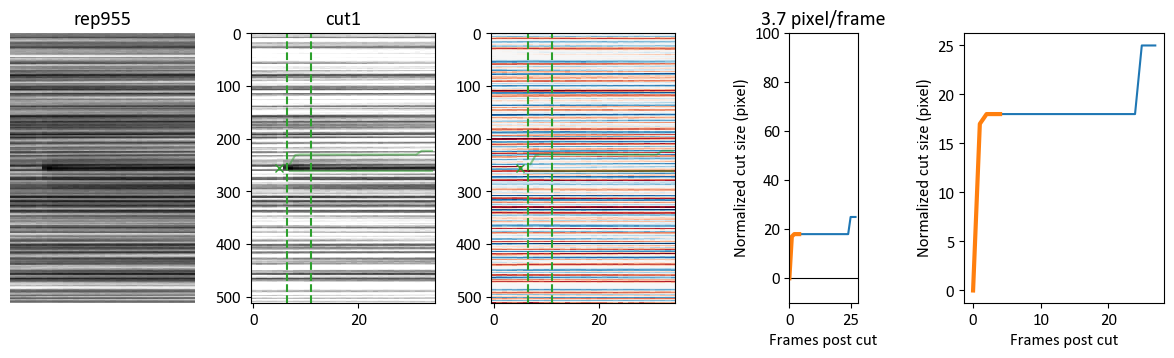

rep 956


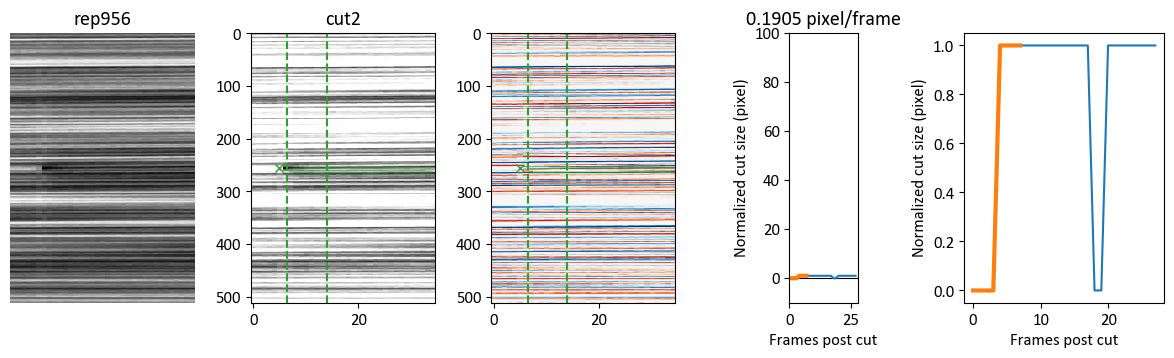

rep 957


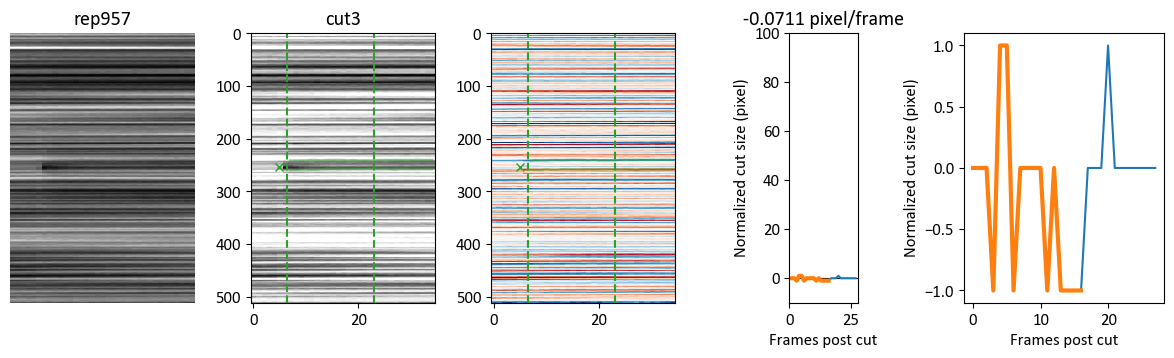

rep 958


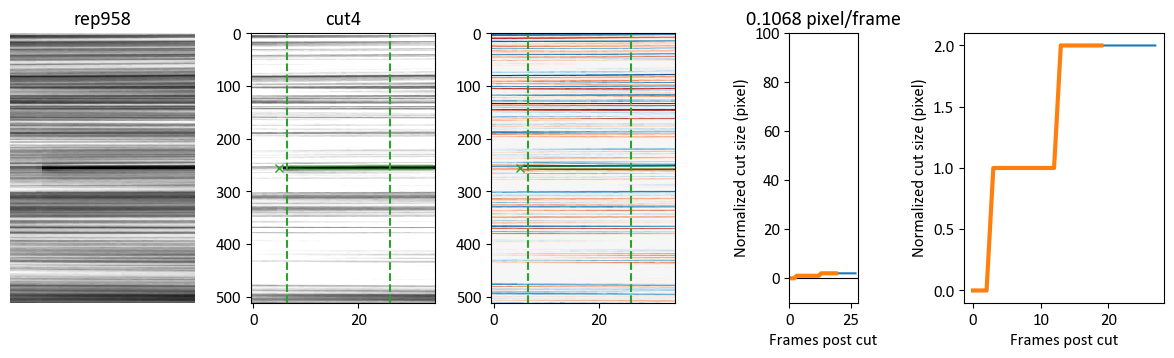

rep 959


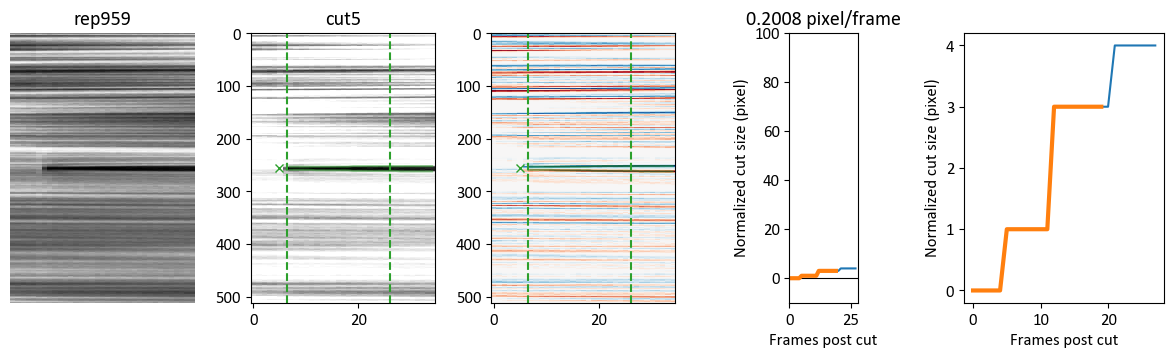

rep 960


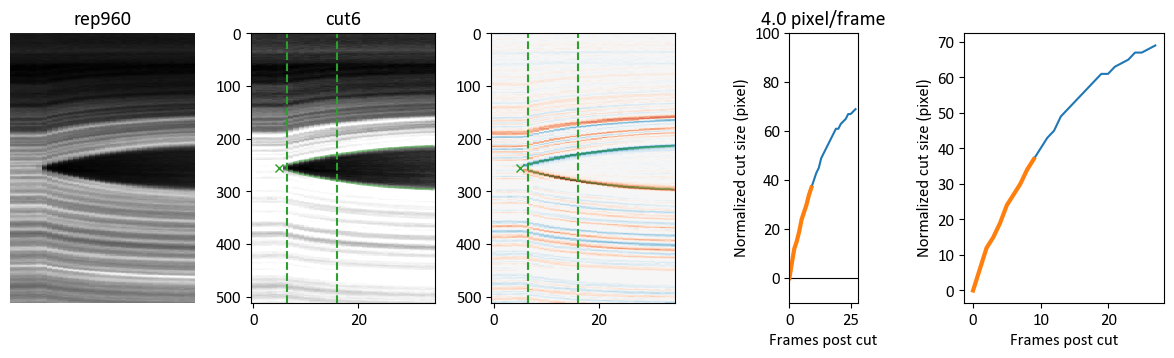

rep 961


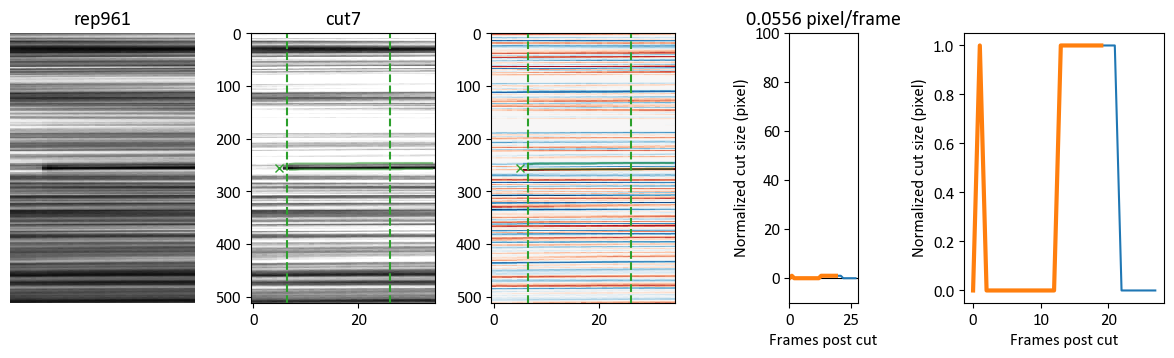

rep 962


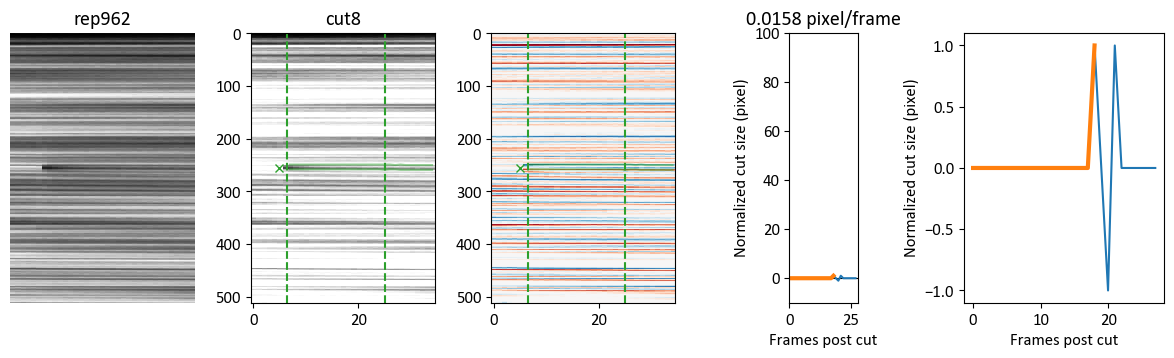

rep 963


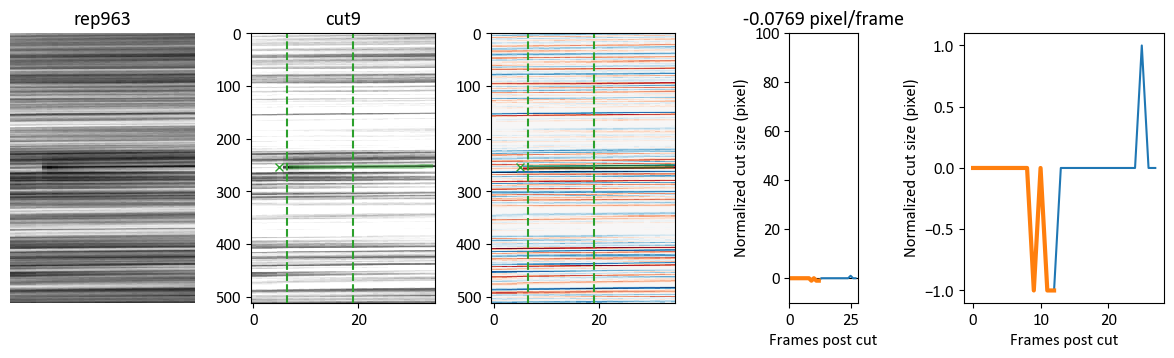

rep 964


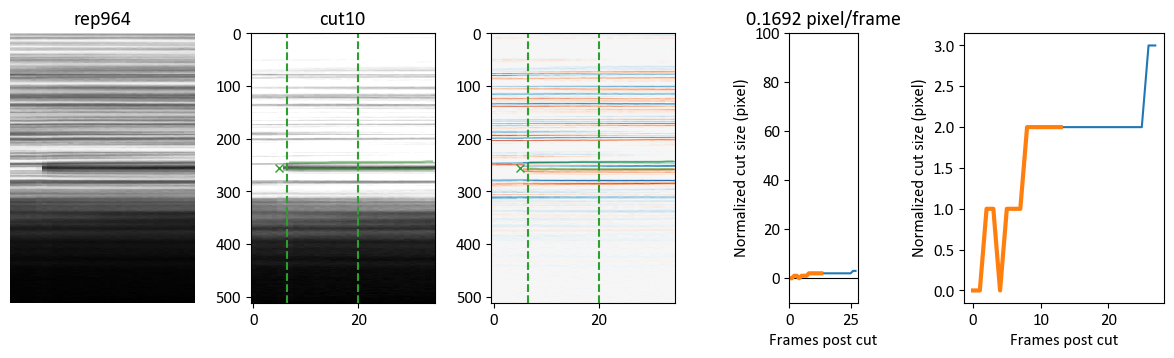

rep 965


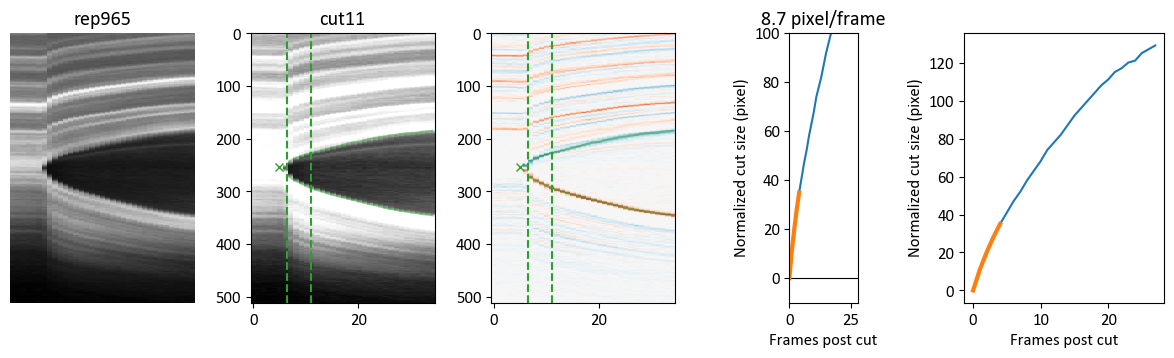

rep 966


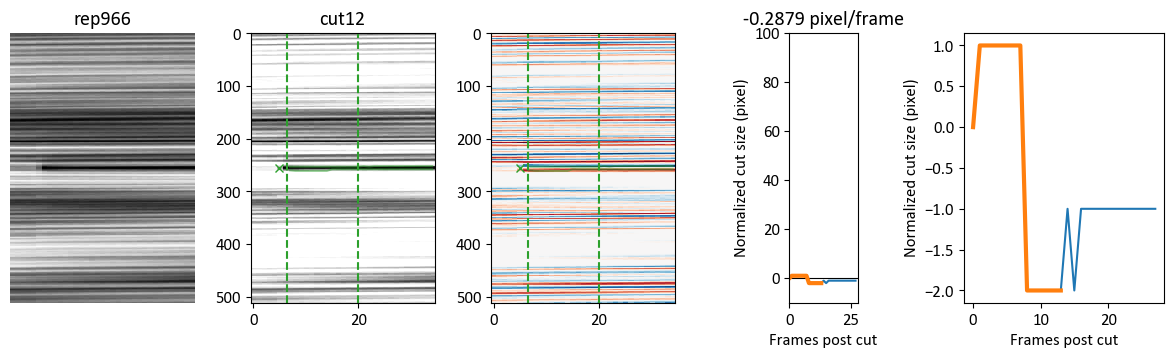

rep 967


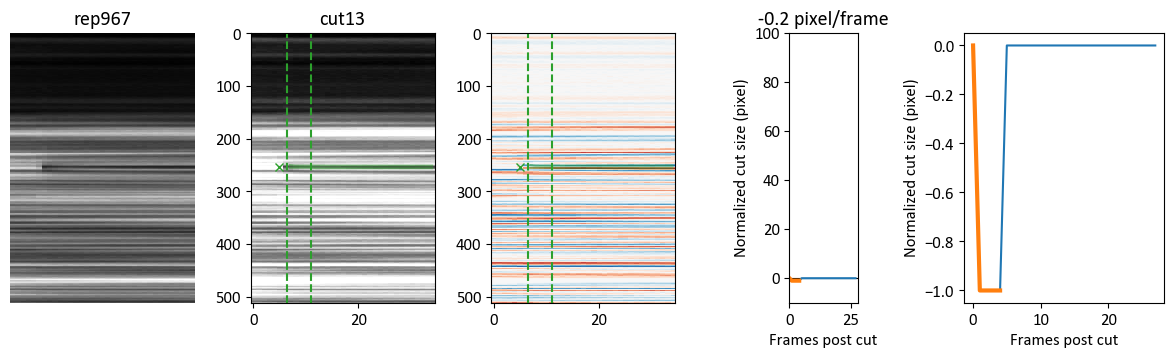

rep 968


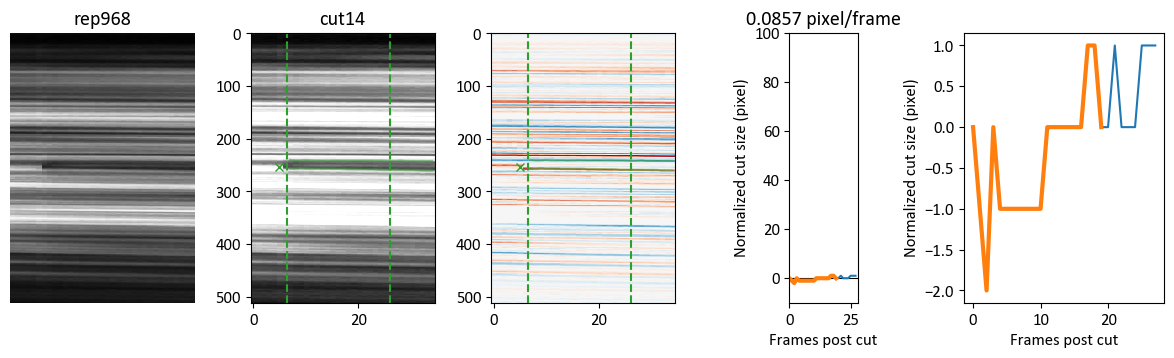

rep 969


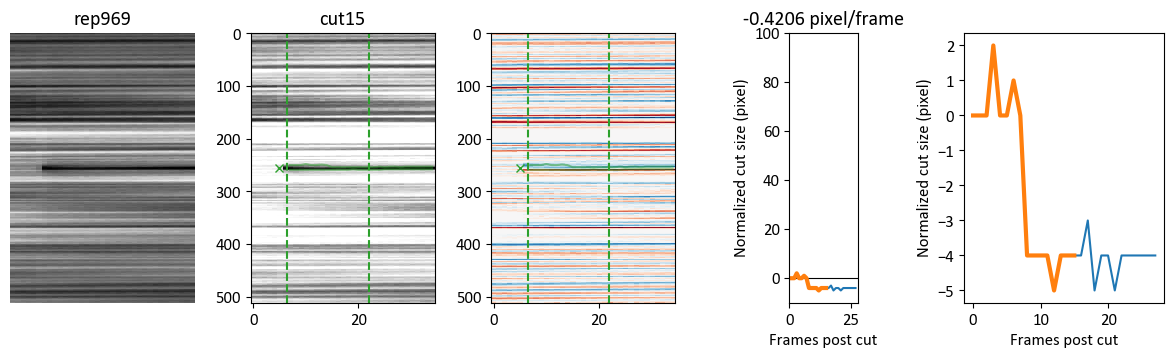

rep 970


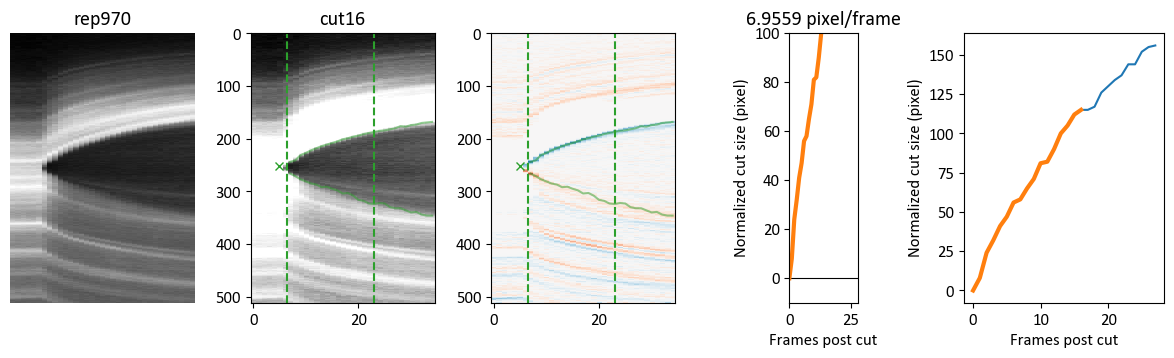

rep 971


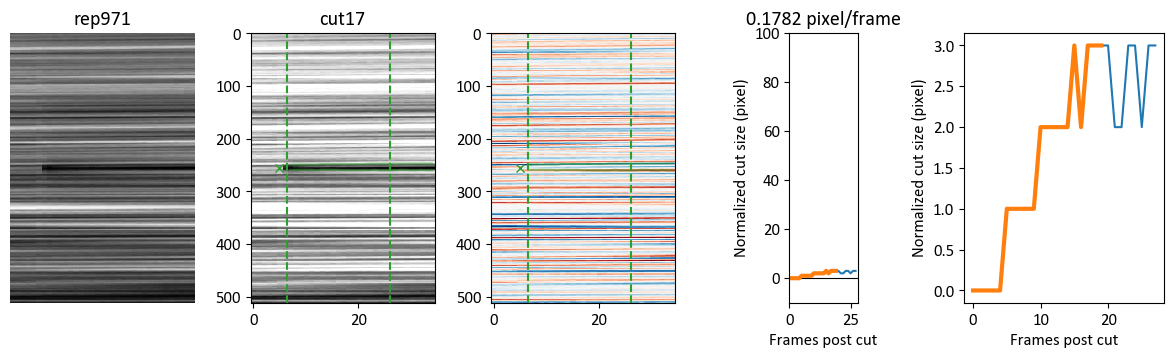

rep 972


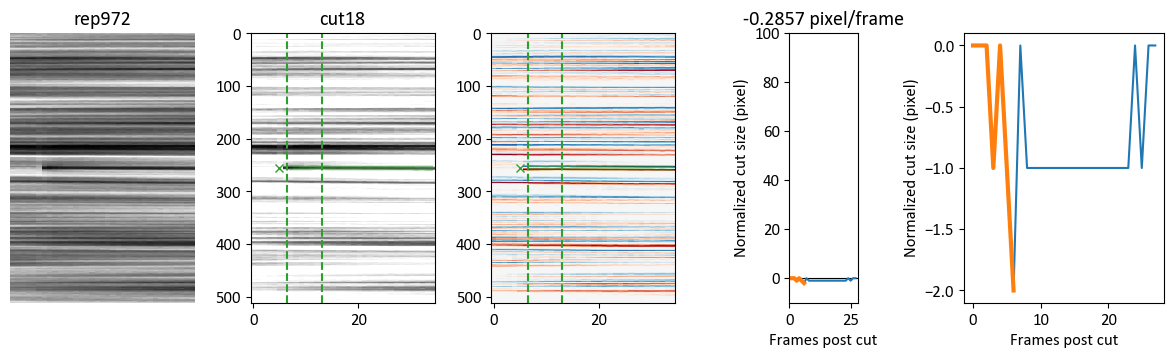

rep 973


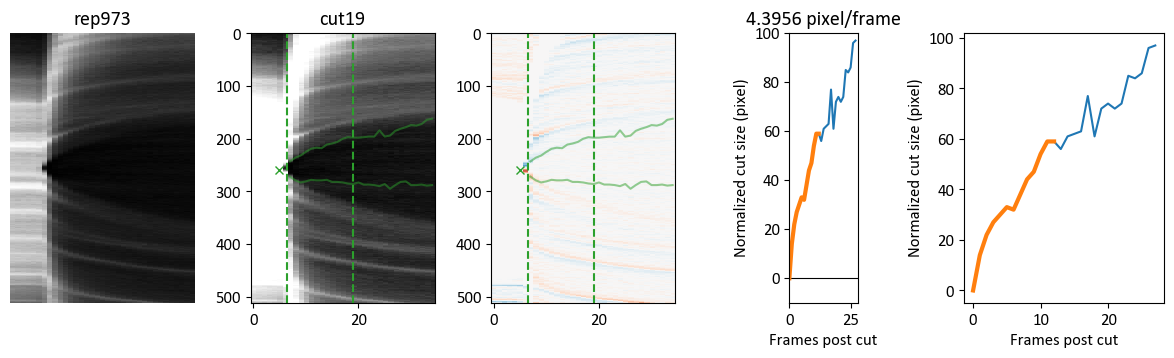

rep 974


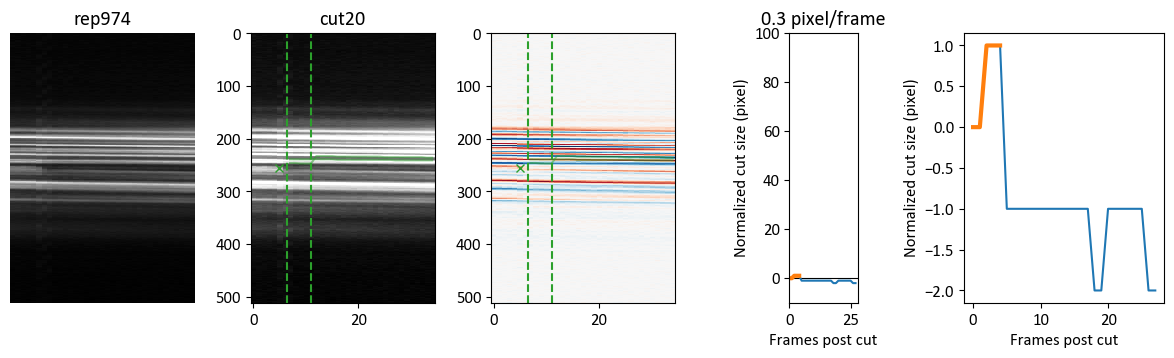

rep 975


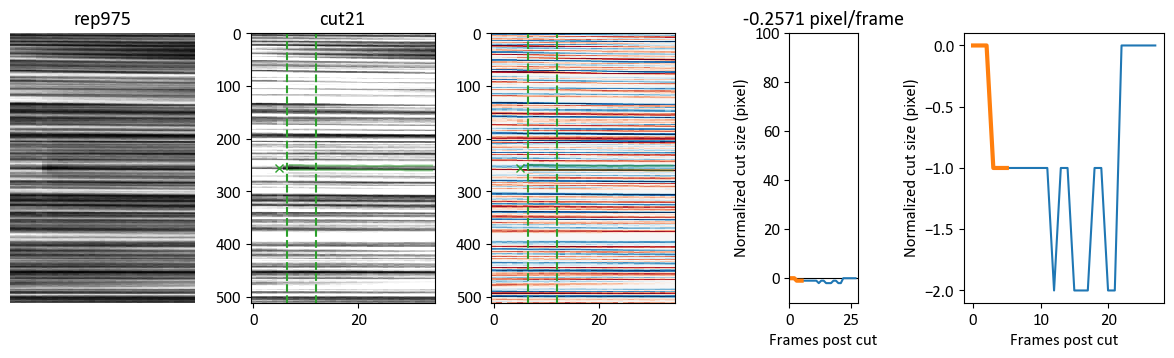

rep 976


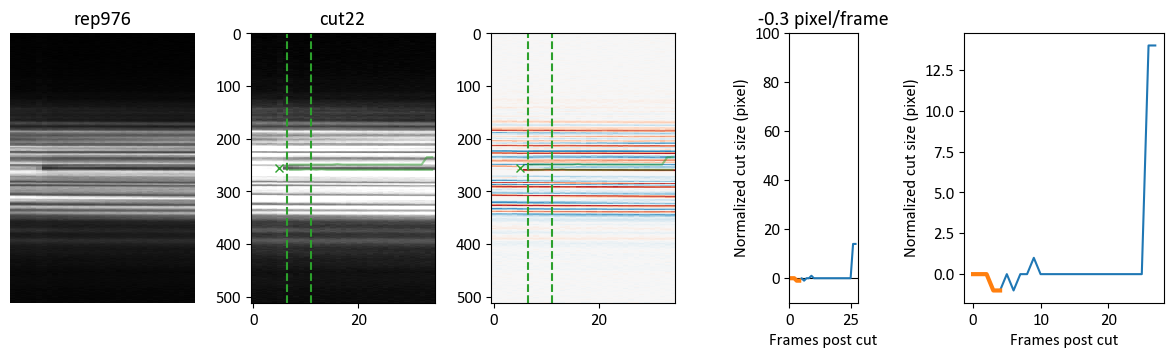

rep 977


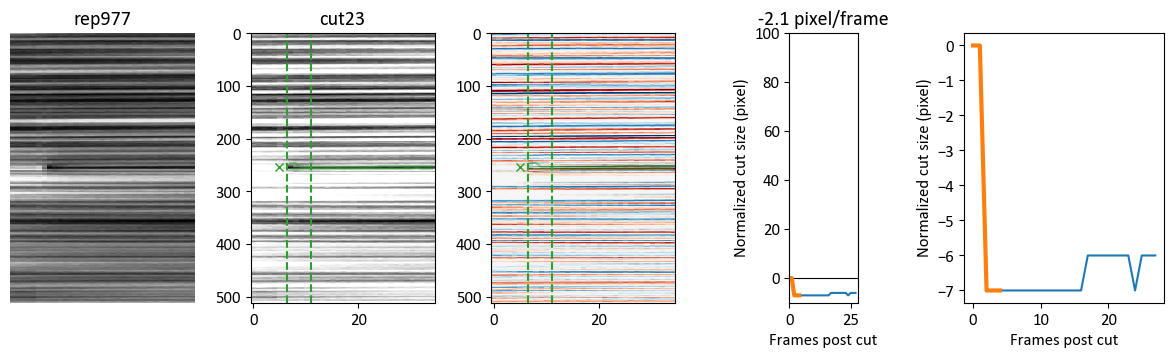

rep 978


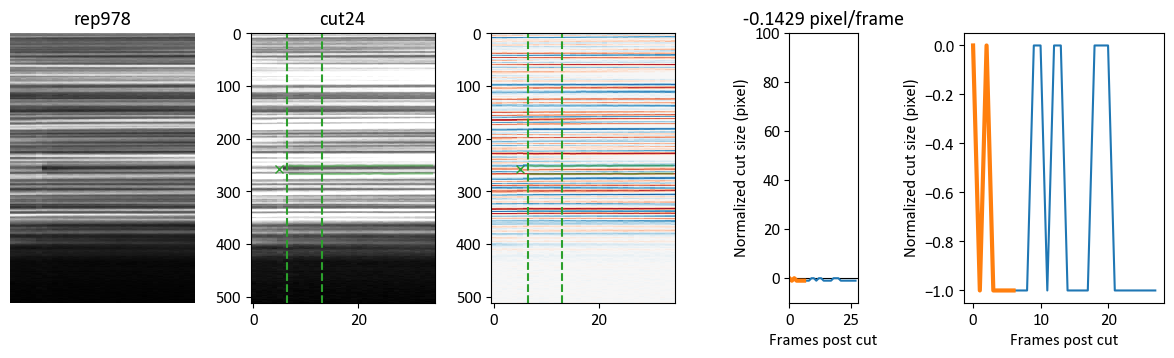

rep 979


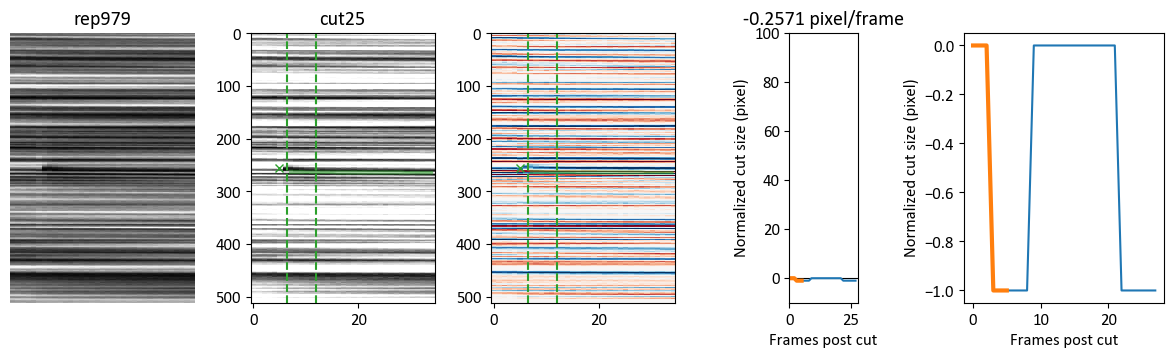

rep 980


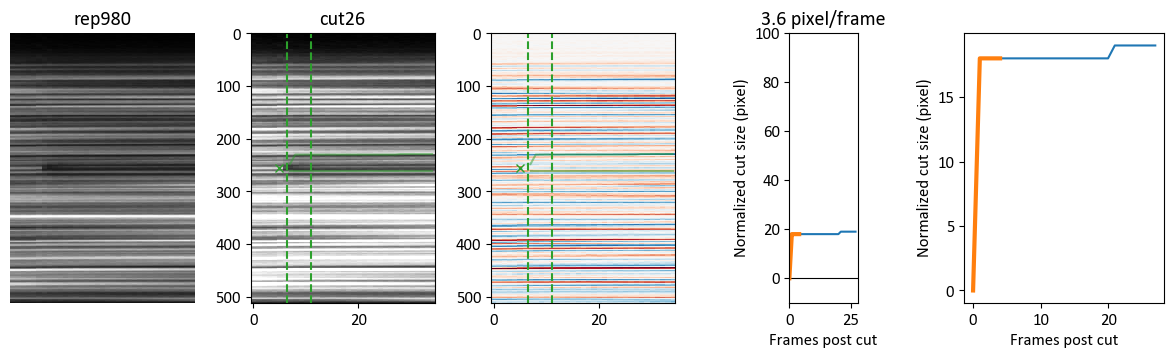

rep 981


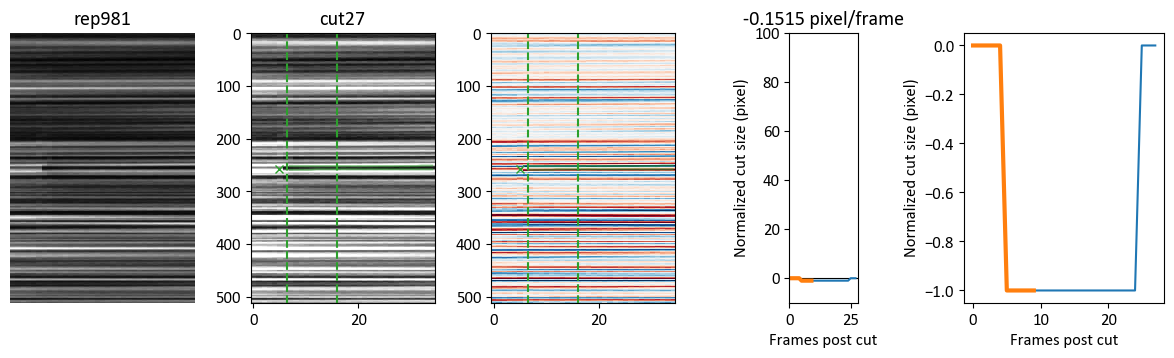

rep 988


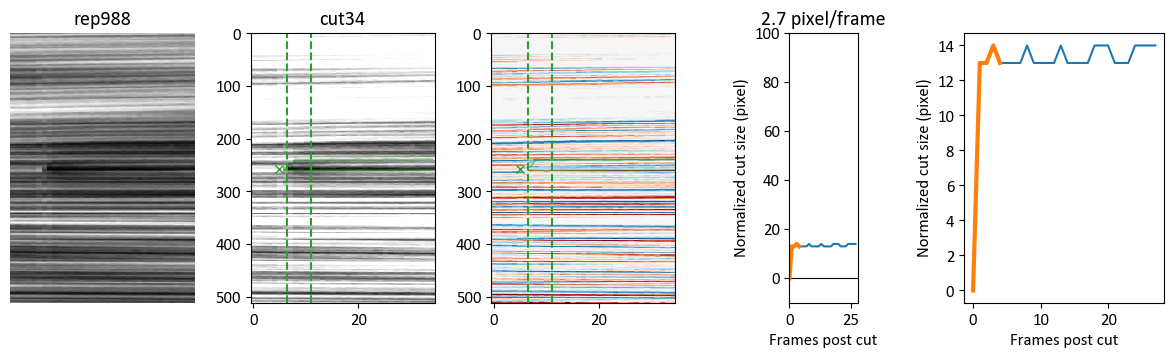

rep 989


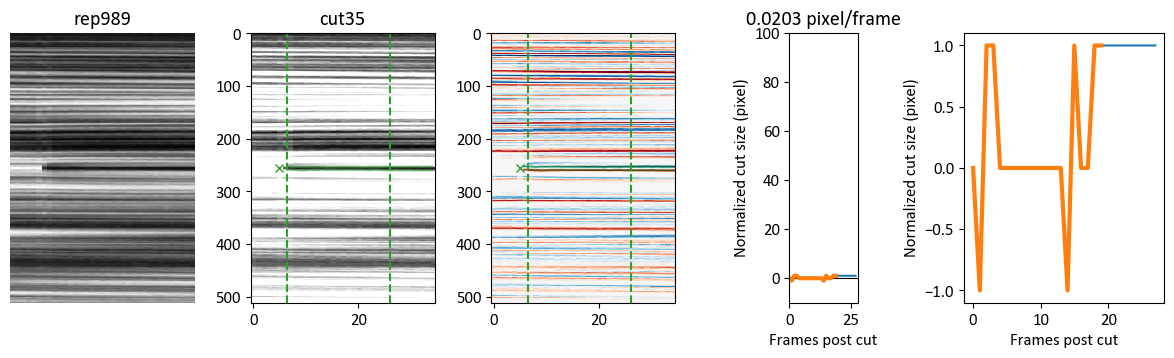

rep 990


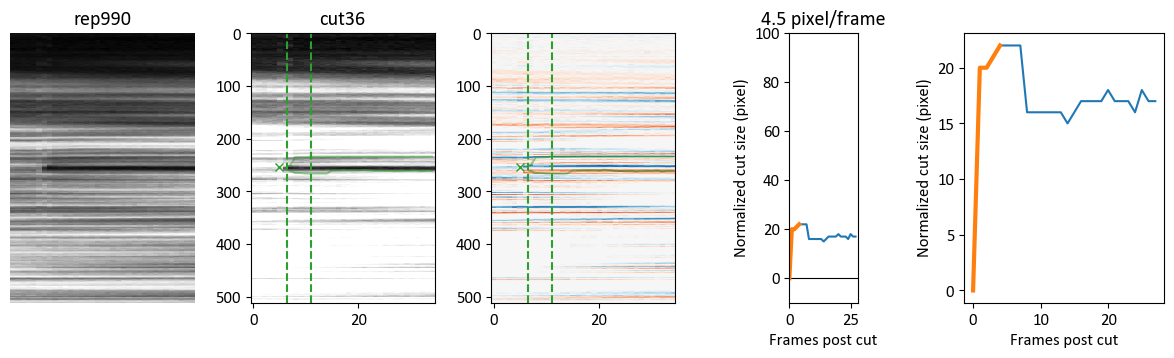

rep 991


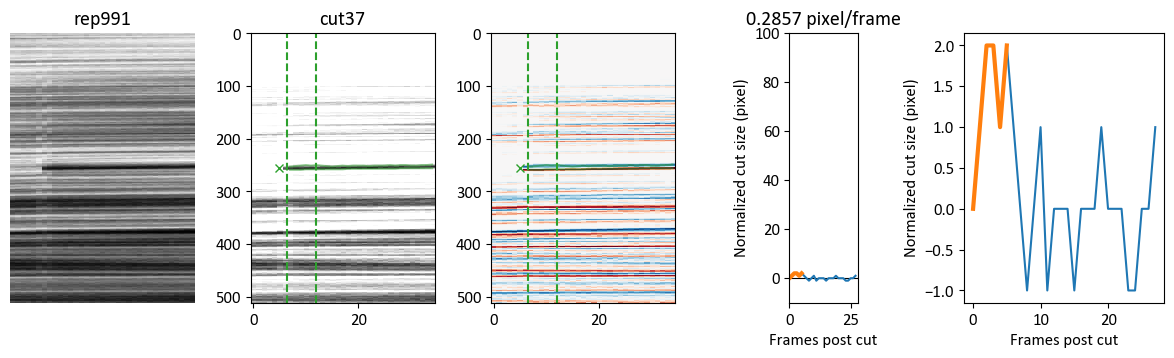

rep 992


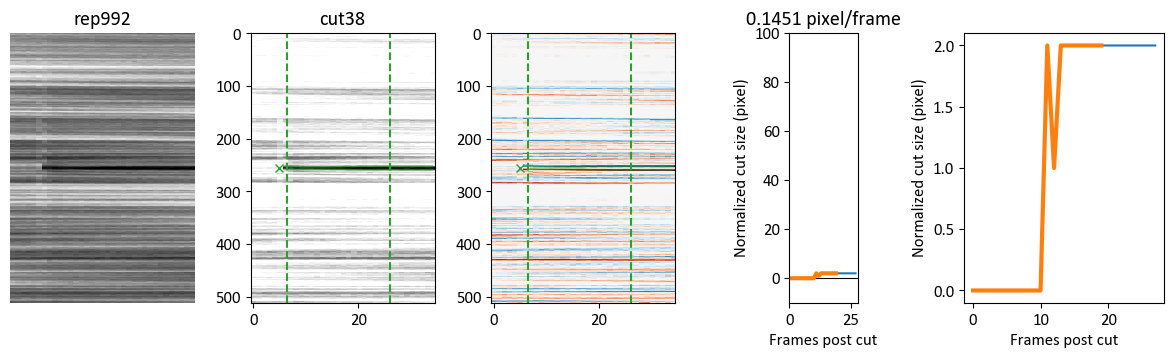

rep 993


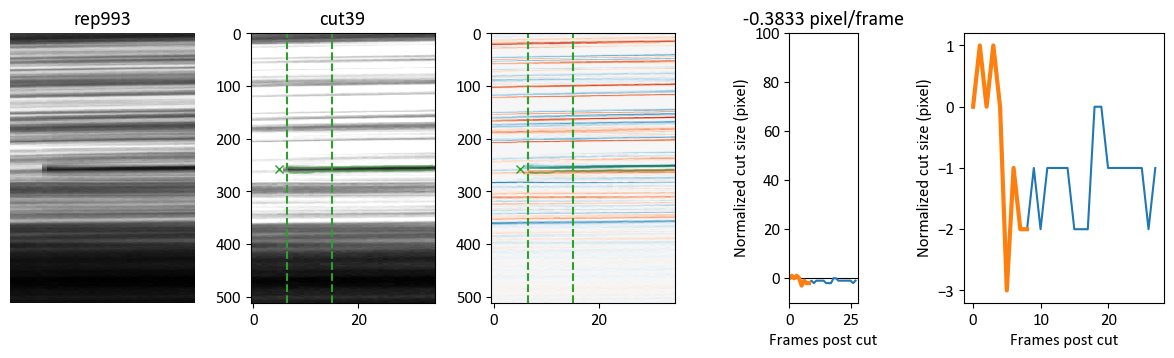

rep 994


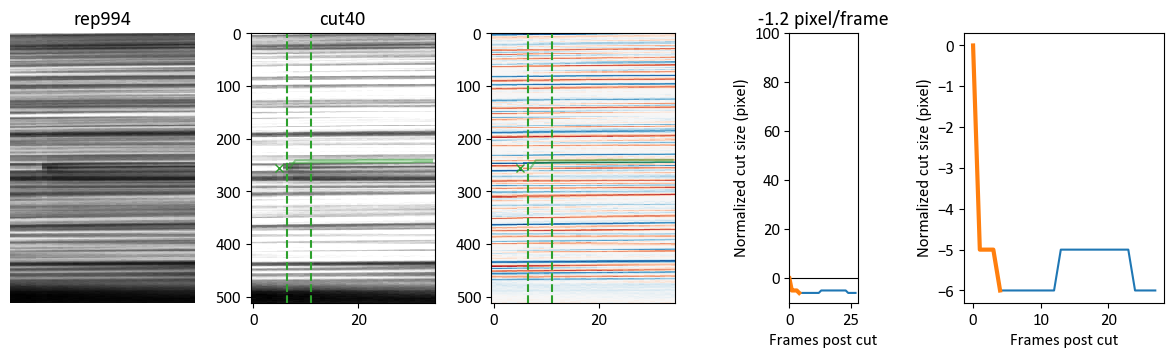

rep 995


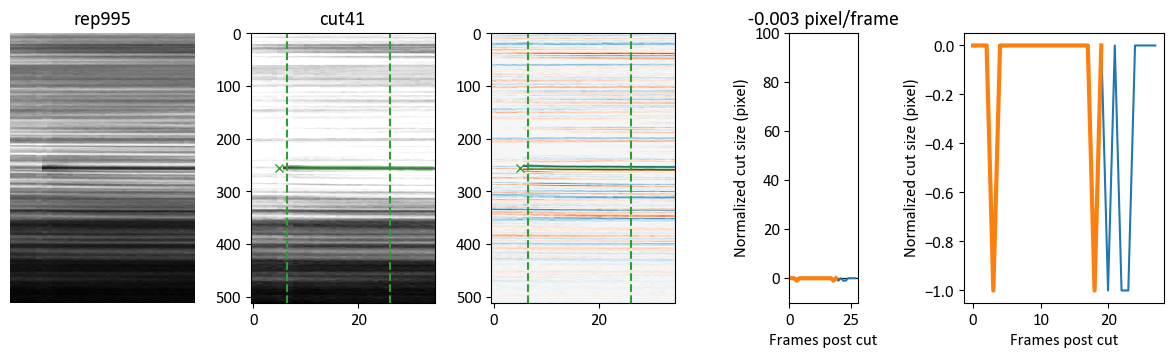

rep 996


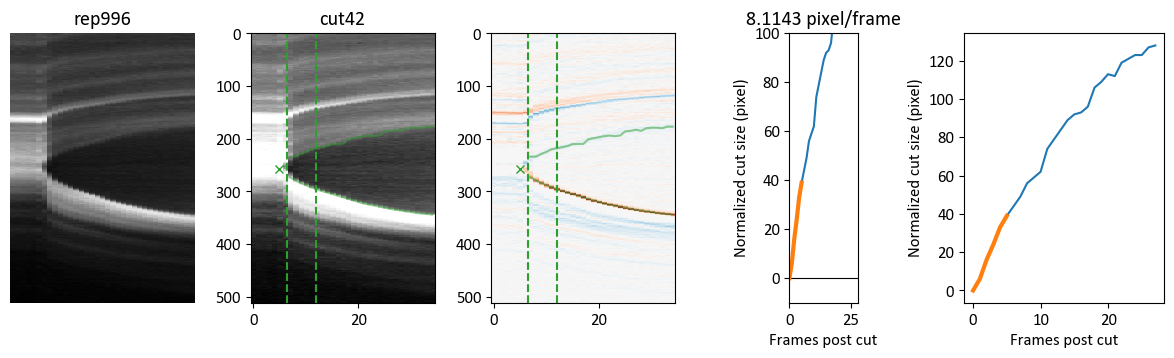

rep 997


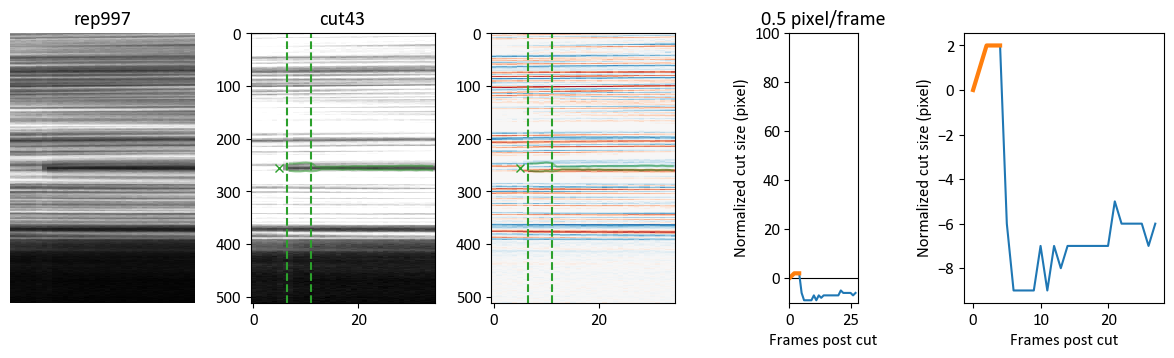

rep 998


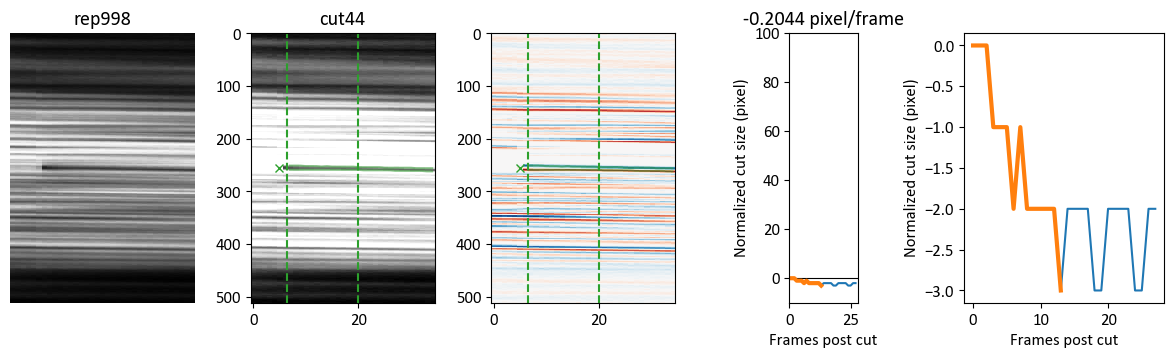

rep 999


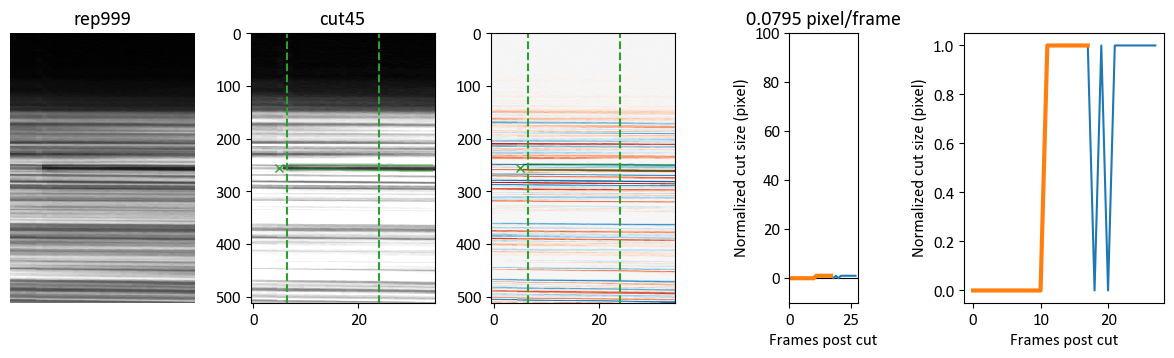

rep 1000


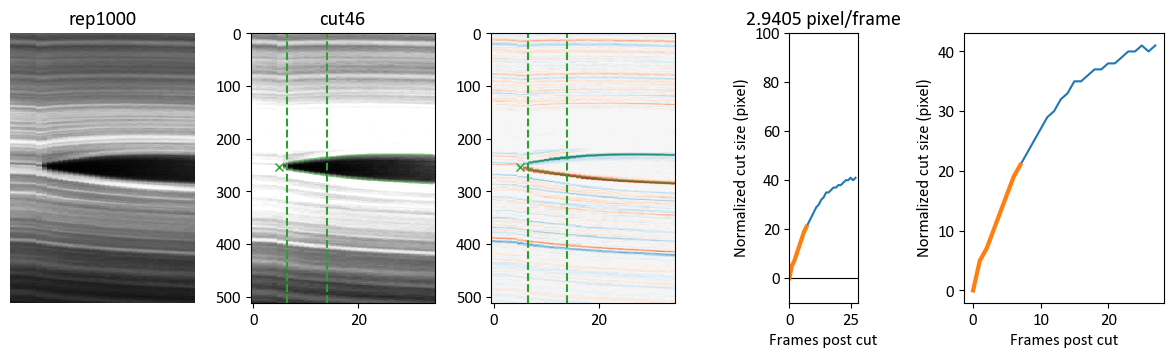

rep 1001


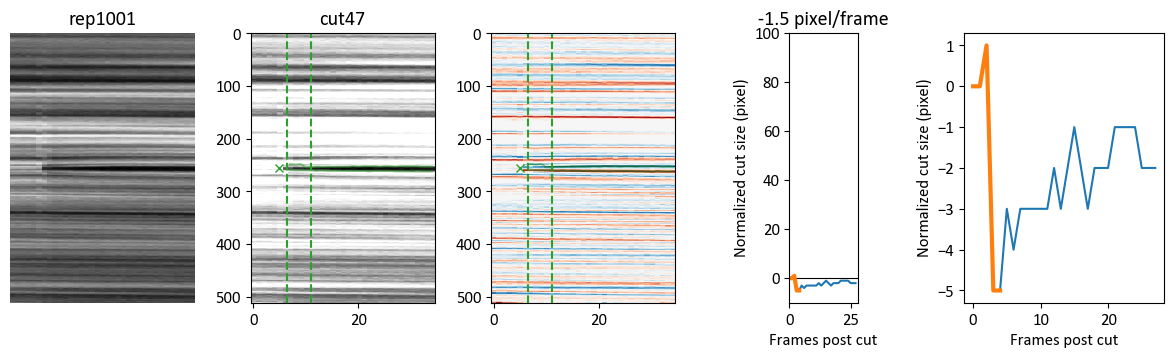

rep 1002


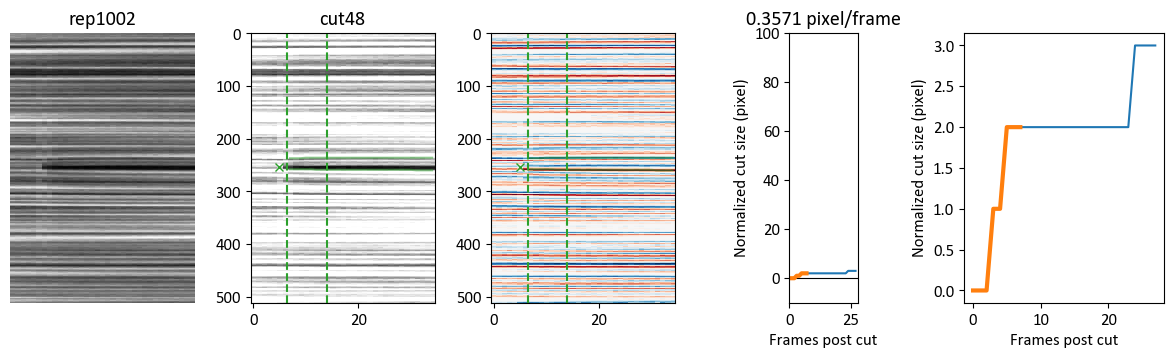

rep 1003


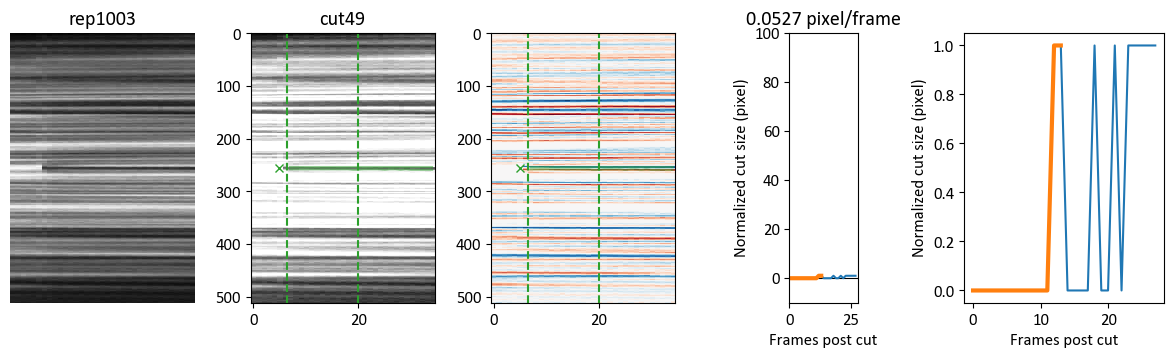

rep 1004


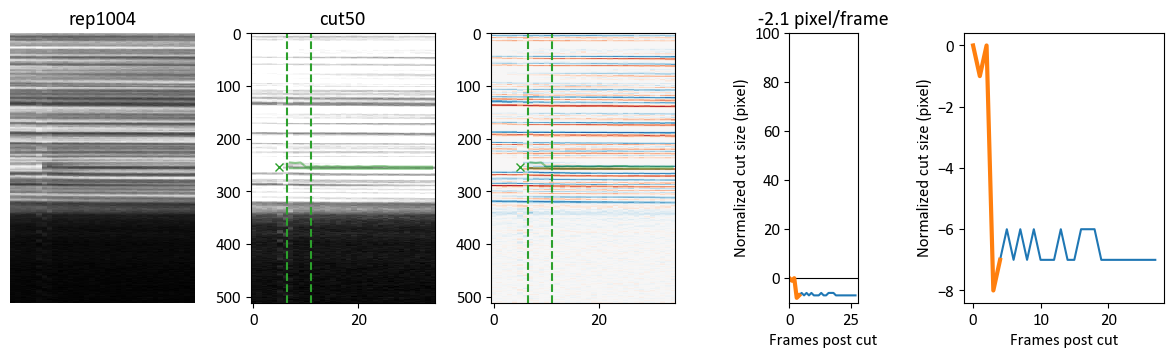

rep 1005


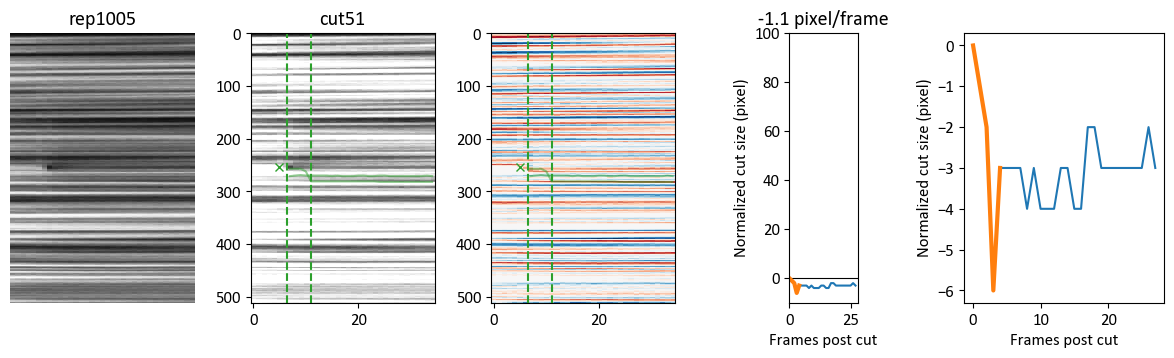

rep 1006


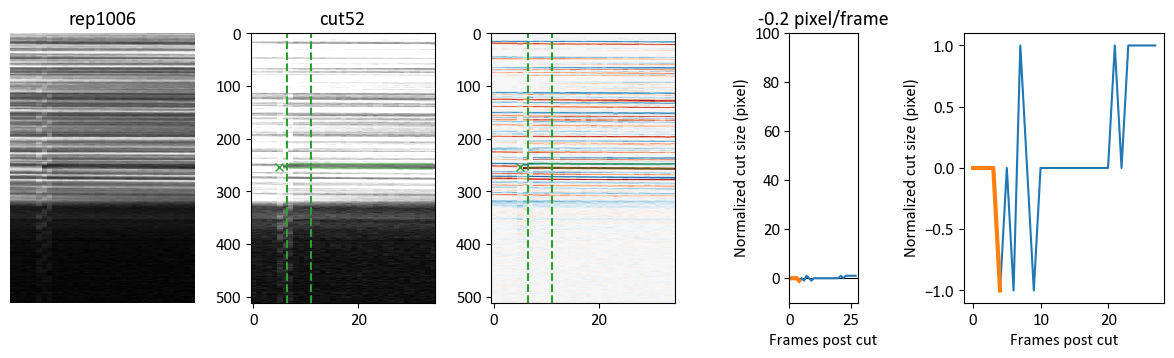

rep 1007


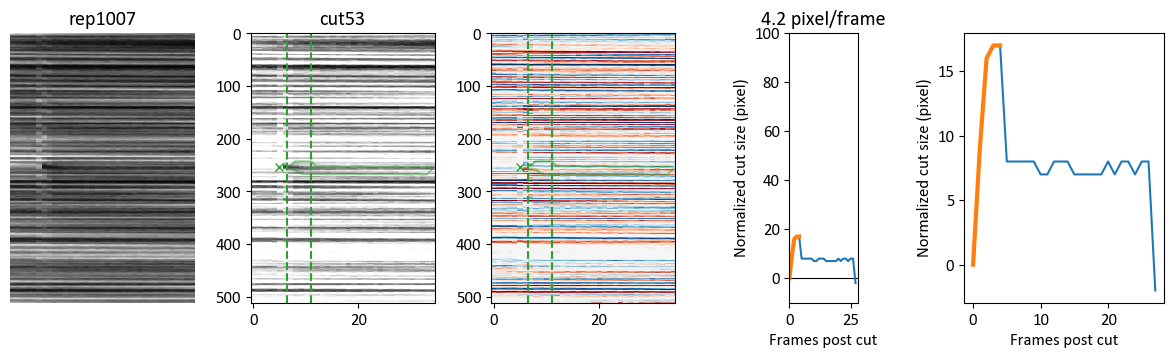

rep 1009


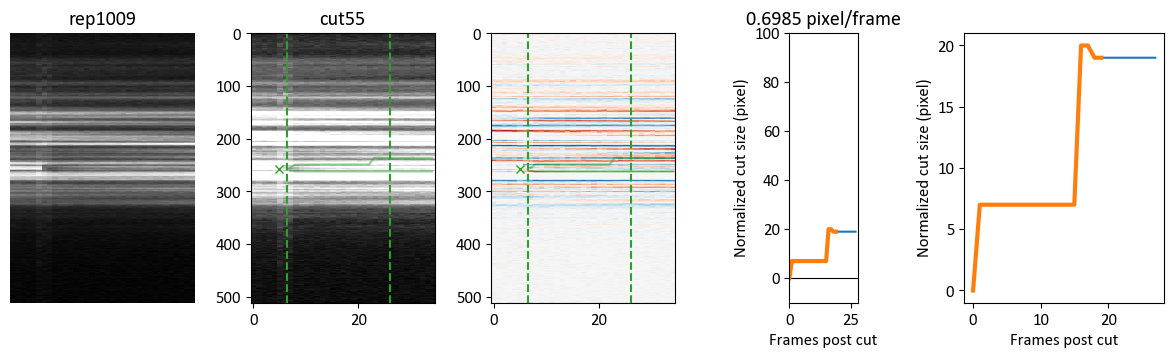

rep 1010


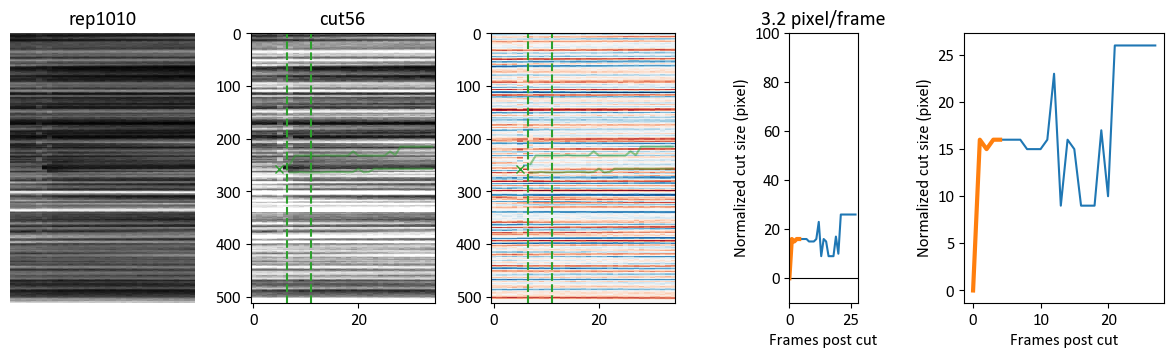

rep 1012


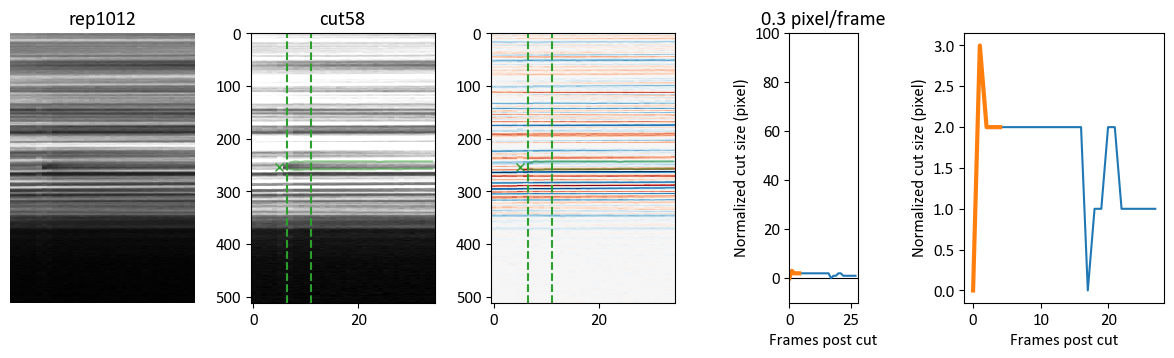

rep 1013


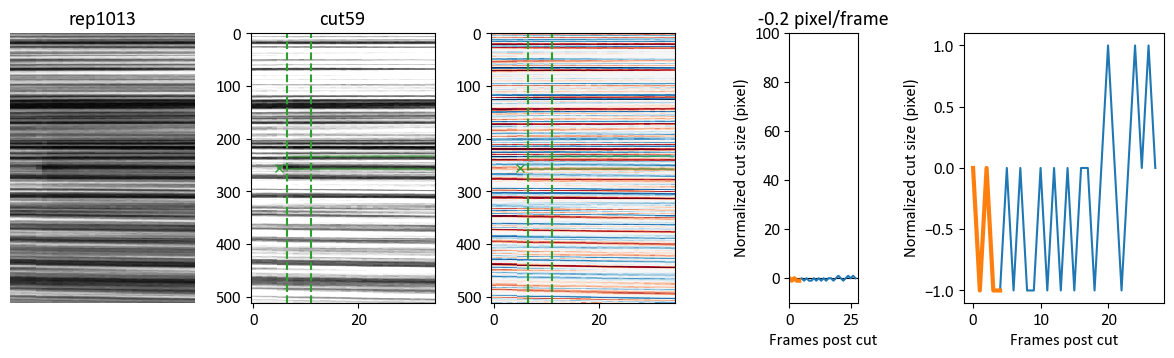

rep 1014


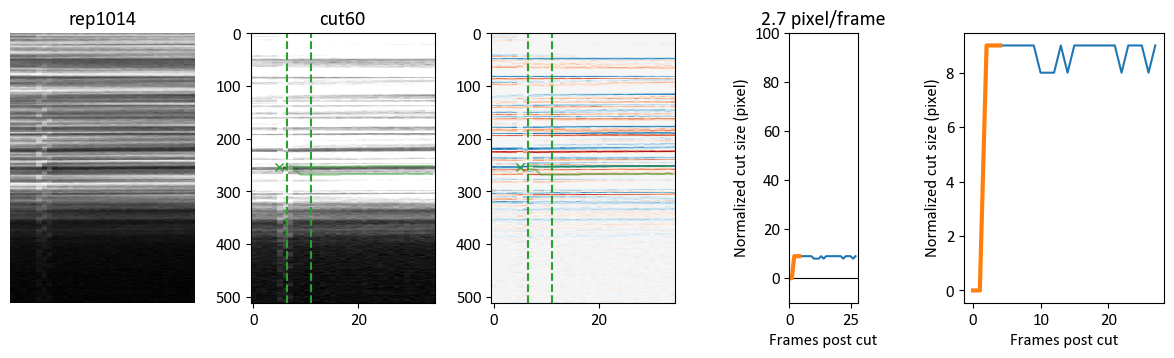

rep 1015


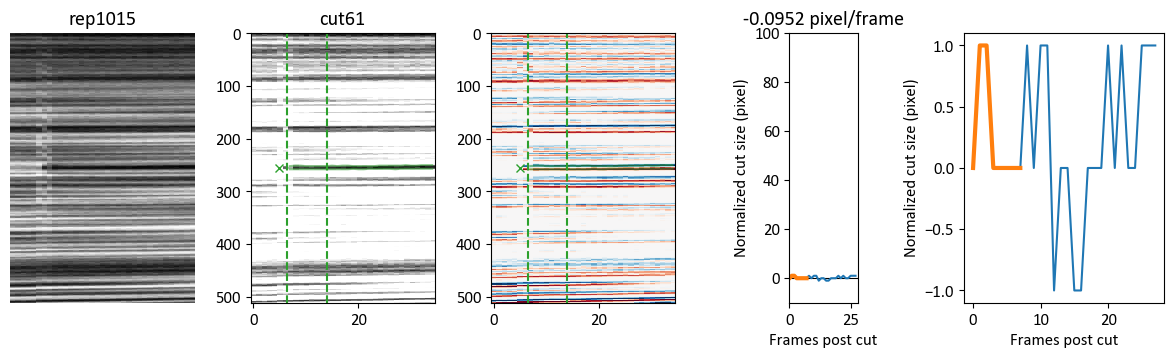

rep  rv_automatic rv_analysis_unit rv_analysis_method rv_analysis_date
955    955      3.700000      pixel/frame          automatic      250724_1321
956    956      0.190476      pixel/frame          automatic      250724_1321
957    957     -0.071078      pixel/frame          automatic      250724_1321
958    958      0.106767      pixel/frame          automatic      250724_1321
959    959      0.200752      pixel/frame          automatic      250724_1321
...    ...           ...              ...                ...              ...
1013  1013     -0.200000      pixel/frame          automatic      250724_1322
1014  1014      2.700000      pixel/frame          automatic      250724_1322
1015  1015     -0.095238      pixel/frame          automatic      250724_1322
1016  1016           NaN              NaN                NaN              NaN
1017  1017           NaN              NaN                NaN              NaN

[63 rows x 5 columns]

 rv_automatic rv_analysis_unit rv_analysis_method rv_analysis_date
     3.700000      pixel/frame          automatic      250724_1321
     0.190476      pixel/frame          automatic      250724_1321
    -0.071078      pixel/frame          automatic      250724_1321
     0.106767      pixel/frame          automatic      250724_1321
     0.200752      pixel/frame          automatic      250724_1321
     4.000000      pixel/frame          automatic      250724_1322
     0.055639      pixel/frame          automatic      250724_1322
     0.015789      pixel/frame          automatic      250724_1322
    -0.076923      pixel/frame          automatic      250724_1322
     0.169231      pixel/frame          automatic      250724_1322
     8.700000      pixel/frame          automatic      250724_1322
    -0.287912      pixel/frame          automatic      250724_1322
    -0.200000      pixel/frame          automatic      250724_1322
     0.085714      pixel/frame          automatic      250724_

'""""""""""""""""""""""""""""""""""""""""""""""""""""""""""'

In [7]:
# for replicates_experiment in replicates_experiments:
for replicates_experiment in ['xin250710_lcii_wt']:
    print(replicates_experiment)

    data_subset = data_collection.loc[data_collection['experiment']==replicates_experiment]

    for i in data_subset.index[:]:
    # for i in [76]:
        replicate = data_subset.loc[i]
        file_name = folder + replicate.experiment + "\\cut" + str(replicate.cut_no) + ".tif"
        if os.path.exists(file_name):
            print('rep', replicate.rep)

            # load raw movie and get the basic info
            pre_cut, post_cut = replicate.pre_cut_frame_num, replicate.post_cut_frame  # 5, 7
            pixel_size, time_interval = replicate.pixel_size, replicate.time_interval
            movie = skimage.io.imread(file_name)
            fs, ys, xs = movie.shape

            # make kymograph
            midy = int(ys/2)
            kymo_raw = np.average(movie[:, midy-kymo_mid_width:midy+kymo_mid_width], axis=1).astype(float)
            
            # kymo processing
            kymo = skimage.exposure.rescale_intensity(kymo_raw, in_range=tuple(np.percentile(kymo_raw[:], (0, 100)) * [1, 0.6]))#, out_range=(0, 1/0.5))
            # kymo = skimage.exposure.rescale_intensity(kymo, in_range=(0, 0.6))
            # kymo = skimage.exposure.equalize_adapthist(kymo_raw/4095, clip_limit=0.03)
            gradient_0, gradient = np.gradient(kymo)
            gradient = scipy.ndimage.gaussian_filter(gradient, sigma=1, axes=1)
            gradients = [-gradient*(gradient<0), gradient*(gradient>0)]
            # gradients = [scipy.ndimage.gaussian_filter(gradient_, sigma=10, axes=1) for gradient_ in gradients]
            gradient = -gradients[0] + gradients[1]

            # plot
            fig,axs=plt.subplots(1,5, figsize=[15, 3.5])
            axs[0].imshow(kymo_raw.T, aspect=to_show_aspect, interpolation='none', cmap='Greys_r') #, vmin=0, vmax=4096)
            axs[0].set_axis_off()
            axs[1].imshow(kymo.T, aspect=to_show_aspect, interpolation='none', cmap='Greys_r', vmin=0, vmax=1)
            axs[2].imshow(gradient.T, aspect=to_show_aspect, interpolation='none', cmap='RdBu_r', vmin=-0.2, vmax=0.2)
            axs[1].axvline(x= post_cut-0.5, color='tab:green', ls='--')
            axs[2].axvline(x= post_cut-0.5, color='tab:green', ls='--')

            axs[0].set_title('rep' + str(replicate.rep))
            axs[1].set_title('cut' + str(replicate.cut_no))
            
            axs[3].set_xlim(0, fs-post_cut)
            axs[3].set_ylim(-10, 100)
            axs[3].axhline(y=0, color='black', lw=0.8)
            axs[3].set_aspect(1)

            # find the recoil boundaries
            try:

                # get the cut_position

                # strategy1: find the lowest point at post_cut
                # cut_position_determinant = scipy.ndimage.gaussian_filter(np.average(kymo[7:10], axis=0), sigma=5)
                # cut_position_determinant_peaks = scipy.signal.find_peaks(-cut_position_determinant, prominence=0.5)
                # cut_position = cut_position_determinant_peaks[0][np.argmax(cut_position_determinant_peaks[1]['prominences'])]

                # strategy2: find the most dropped point at post_cut
                cut_position_determinant = scipy.ndimage.gaussian_filter(np.average(kymo[7:10], axis=0) - np.average(kymo[:pre_cut], axis=0), sigma=2)
                cut_position_determinant_peaks = scipy.signal.find_peaks(-cut_position_determinant, prominence=0.2)
                cut_position = cut_position_determinant_peaks[0][np.argmax(cut_position_determinant_peaks[1]['prominences'])]

                axs[1].plot(pre_cut, cut_position, 'x', color='tab:green')
                axs[2].plot(pre_cut, cut_position, 'x', color='tab:green')
                # cut_position = np.argmin(cut_position_determinant[int(xs/2)-100:int(xs/2)+100])+int(xs/2)-100
                # cut_position = np.argmin(kymo[post_cut, int(xs/2)-100:int(xs/2)+100])+int(xs/2)-100
                # cut_position = np.argmin(gradient_0[post_cut, int(xs/2)-100:int(xs/2)+100])+int(xs/2)-100

                # fig, ax = plt.subplots(figsize=[3,2])
                # [ax.plot(kymo_raw[i], color='tab:blue') for i in range(5)]
                # [ax.plot(kymo_raw[i], color='tab:orange') for i in range(8,13)]
                # ax.plot(cut_position_determinant, color='tab:green')
                # ax.plot(cut_position, cut_position_determinant[cut_position], 'x', color='tab:red')
                # plt.show()

                u_b = cut_position
                l_b = cut_position
                recoil_boundaries = []

                for f in range(post_cut, fs):
                    try:

                        if 0: # strategy 1
                            recoil_center = int((u_b + l_b)/2)

                            search_region = gradients[0][f, u_b-int(search_range/2):recoil_center]
                            thresh = np.percentile(search_region, 80) 
                            search_peaks, _ = scipy.signal.find_peaks(search_region, height=thresh)
                            peaks = np.array(search_peaks) + u_b - int(search_range/2)
                            u_b_to_be = closest(peaks, u_b)[1]
                            if f==post_cut:
                                u_b = u_b_to_be
                            else:
                                if gradients[0][f-1, u_b]*0.9<= gradients[0][f, u_b_to_be] <= gradients[0][f-1, u_b]*1.1:
                                    u_b = u_b_to_be
                                else:
                                    peak = search_peaks[closest(search_region[search_peaks], -gradients[0][f-1, u_b])[0]]
                                    peak += u_b-int(search_range/2)
                                    u_b = peak

                            search_region = gradients[1][f, recoil_center:l_b+int(search_range/2)]
                            thresh = np.percentile(search_region, 80)
                            search_peaks, _ = scipy.signal.find_peaks(search_region, height=thresh)
                            peaks = np.array(search_peaks) + recoil_center
                            l_b_to_be = closest(peaks, l_b)[1]
                            if f==post_cut:
                                l_b = l_b_to_be
                            else:
                                if gradients[1][f-1, l_b]*0.9 <= gradients[1][f, l_b_to_be] <= gradients[1][f-1, l_b]*1.1:
                                    l_b = l_b_to_be
                                else:
                                    peak = search_peaks[closest(search_region[search_peaks], gradients[1][f-1, l_b])[0]]
                                    peak += recoil_center
                                    l_b = peak

                        if 1: # strategy 2
                            recoil_center = int((u_b + l_b)/2)

                            thresh = np.percentile(gradients[0][f, u_b-int(search_range/2):recoil_center], 90)
                            zone1 = gradients[0][f]>thresh
                            ind = closest(lst=np.where(zone1)[0], K=u_b)[1]
                            zone1 = scipy.ndimage.label(zone1)[0]
                            zone1 = zone1 == zone1[ind]
                            zone1 = zone1 * gradients[0][f]
                            u_b = index_to_half_total(zone1)

                            thresh = np.percentile(gradients[1][f, recoil_center:l_b+int(search_range/2)], 90)
                            zone1 = gradients[1][f]>thresh
                            ind = closest(lst=np.where(zone1)[0], K=l_b)[1]
                            zone1 = scipy.ndimage.label(zone1)[0]
                            zone1 = zone1 == zone1[ind]
                            zone1 = zone1 * gradients[1][f]
                            l_b = index_to_half_total(zone1)

                        recoil_boundaries.append([u_b, l_b])
                    except:
                        break
                recoil_boundaries = np.array(recoil_boundaries)

                # mask = np.zeros_like(kymo)
                # for f in range(post_cut, post_cut+lin_detect_end):
                #     recoil_center = int(np.mean(recoil_boundaries[f-post_cut]))
                #     recoil_center_intensity = kymo[f, recoil_center-1:recoil_center+2]
                #     mask[f] = (scipy.ndimage.gaussian_filter(kymo[f], sigma=5) < recoil_center_intensity.mean()*3)
                #     axs[6].plot(scipy.ndimage.gaussian_filter(kymo[f], sigma=5)[recoil_center-200:recoil_center+200])

                axs[1].plot(range(post_cut, post_cut+len(recoil_boundaries)), recoil_boundaries, color='tab:green', alpha=.5)
                axs[2].plot(range(post_cut, post_cut+len(recoil_boundaries)), recoil_boundaries, color='tab:green', alpha=.5)

                boundaries_width, lin_end, vel = init_vel(recoil_boundaries, pixel_size=1, time_interval=1,
                                                lin_detect_start = lin_detect_start, lin_detect_end = lin_detect_end,
                                                start = 0, axs=[axs[3], axs[4]])
                axs[1].axvline(x= post_cut+lin_end-1, color='tab:green', ls='--')
                axs[2].axvline(x= post_cut+lin_end-1, color='tab:green', ls='--')
                axs[3].set_title(str(round(vel, 4)) + " pixel/frame")

                data_subset.loc[i, 'rv_automatic'] = vel
                data_subset.loc[i, 'rv_analysis_unit'] = 'pixel/frame'
                data_subset.loc[i, 'rv_analysis_method'] = 'automatic'
                data_subset.loc[i, 'rv_analysis_date'] = str(datetime.now().strftime(r"%y%m%d_%H%M"))
            except:
                print('Segmentation failed')

            plt.savefig(file_name[:-4] + "_rv_analysis.png", bbox_inches = 'tight', pad_inches = 0.1, dpi=250)
            plt.show()
            # plt.close()

    data_collection_rv = data_subset[['rep', 'rv_automatic', 'rv_analysis_unit', 'rv_analysis_method', 'rv_analysis_date']]
    data_collection_rv.to_excel("H:\\Xin home drive\\data_meroblastic\\Laser_cutter\\laser_cutter_ii\\" + replicates_experiment + "\\" + replicates_experiment + "_rv_analysis_" + datetime.now().strftime(r"%y%m%d")+ ".xlsx")
    display(data_collection_rv)
    print(data_collection_rv[['rv_automatic', 'rv_analysis_unit', 'rv_analysis_method', 'rv_analysis_date']].to_string(index=False))
    display('""""""""""""""""""""""""""""""""""""""""""""""""""""""""""')


